https://picturemushroom.com/region/United-States-North-Carolina.html

In [12]:
import os
import tensorflow as tf

# os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

print("TensorFlow version:", tf.__version__)
print("Available GPU :", tf.config.list_physical_devices('GPU'))
print("Is Built with CUDA:", tf.test.is_built_with_cuda())

TensorFlow version: 2.14.1
Available GPU : [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Is Built with CUDA: True


In [13]:
img_height, img_width = 224, 224
batch_size = 32

train_ds = tf.keras.utils.image_dataset_from_directory(
    "dataset/train",
    image_size = (img_height, img_width),
    batch_size = batch_size
)
val_ds = tf.keras.utils.image_dataset_from_directory(
    "dataset/val",
    image_size = (img_height, img_width),
    batch_size = batch_size
)
test_ds = tf.keras.utils.image_dataset_from_directory(
    "dataset/test",
    image_size = (img_height, img_width),
    batch_size = batch_size
)

Found 2004 files belonging to 20 classes.
Found 373 files belonging to 20 classes.
Found 137 files belonging to 20 classes.


Classes found: ['edible-Boletus_edulis', 'edible-Cantharellus_cibarius', 'edible-Flammulina_velutipes', 'edible-Grifola_frondosa', 'edible-Hericium_erinaceus', 'edible-Lactarius_deliciosus', 'edible-Laetiporus_sulphureus', 'edible-Leccinum_scabrum', 'edible-Morchella_esculenta', 'edible-Pleurotus_ostreatus', 'inedible-Armillaria_mellea', 'inedible-Clitocybe_nebularis', 'inedible-Clitocybe_rivulosa', 'inedible-Ganoderma_applanatum', 'inedible-Ganoderma_lucidum', 'inedible-Hericium_cirrhatum', 'inedible-Inonotus_obliquus', 'inedible-Lactarius_chrysorrheus', 'inedible-Lactarius_necator', 'inedible-Trametes_versicolor']
Number of classes: 20


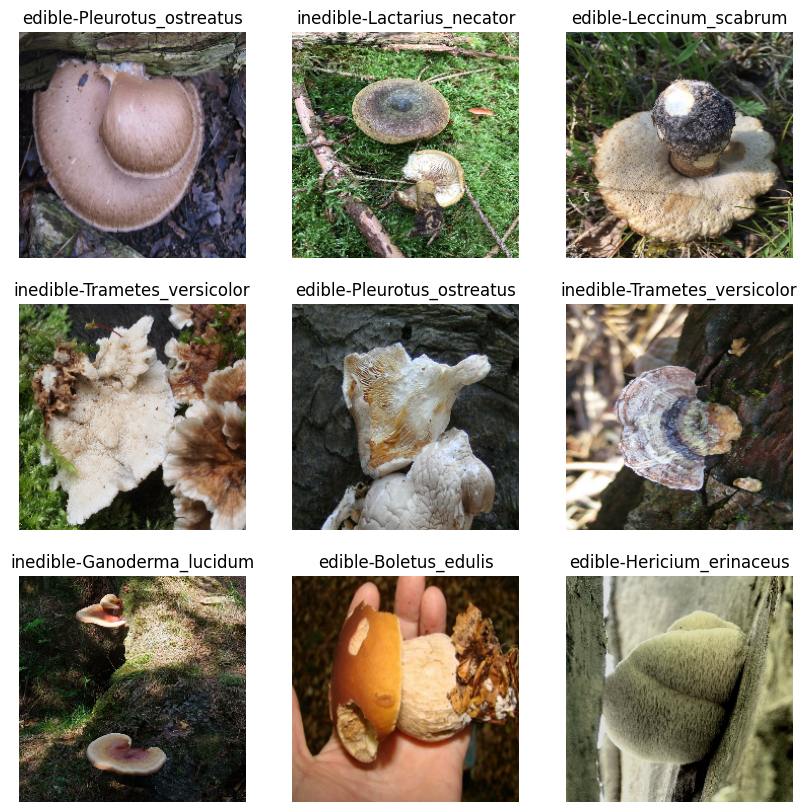

In [14]:
import matplotlib.pyplot as plt

classes = os.listdir('dataset/train')
classes.sort()
num_classes = len(classes)

print("Classes found:", classes)
print("Number of classes:", num_classes)

plt.figure(figsize=(10,10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(classes[labels[i]])
    plt.axis("off")

plt.show()

In [ ]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [4]:
from keras.layers import RandomTranslation, RandomContrast, RandomBrightness, RandomFlip, RandomRotation, RandomZoom
from keras import Sequential

data_augmentation = Sequential([
    RandomFlip("horizontal"),
    # RandomFlip("vertical"),
    RandomRotation(0.2),
    RandomZoom(0.1),
    # RandomContrast(0.2),
    # RandomBrightness(0.2),
    # RandomTranslation(height_factor=0.2, width_factor=0.2)
])

In [5]:
augmented_train_ds = train_ds.map(lambda x, y: (data_augmentation(x, training=True), y))

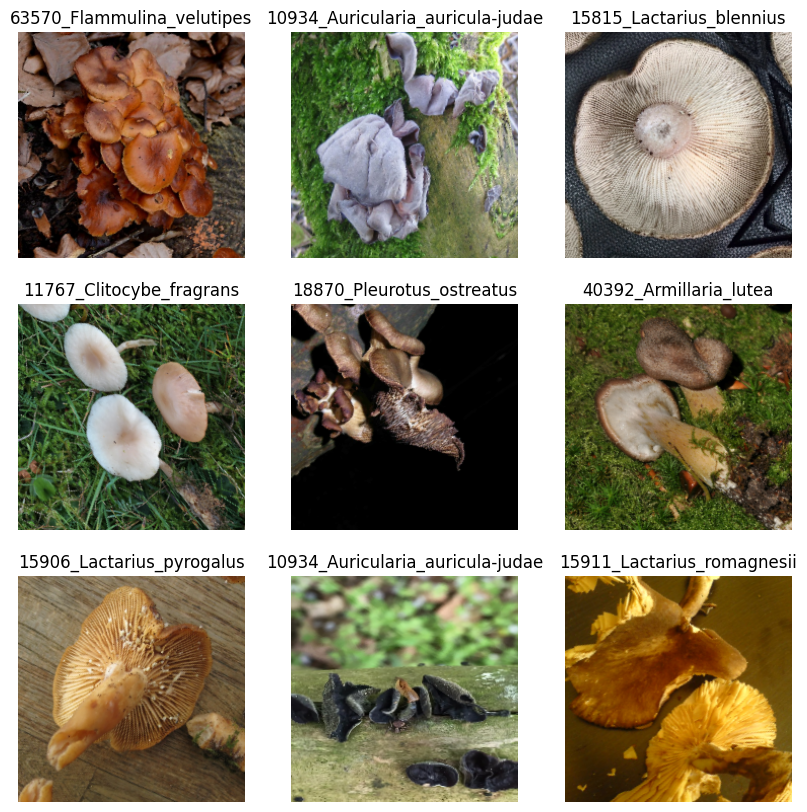

In [6]:
plt.figure(figsize=(10,10))

for images, labels in train_ds.take(1):
    augmented_images = data_augmentation(images)
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)  # Positioning in the second row
        plt.imshow(augmented_images[i].numpy().astype("uint8"))
        plt.title(classes[labels[i]])
        plt.axis("off")

plt.show()

In [7]:
from keras.applications import MobileNetV2

base_model = MobileNetV2(
    input_shape=(img_height, img_width, 3), 
    include_top=False, 
    weights='imagenet'
    )

freeze_up_to = 100

for layer in base_model.layers[:freeze_up_to]:
    layer.trainable = False

In [8]:
from keras.layers import GlobalAveragePooling2D, Dense, Dropout
from keras.regularizers import l2

model = Sequential([
    data_augmentation,
    base_model,
    GlobalAveragePooling2D(),
    Dense(128, activation='relu', kernel_regularizer=l2(0.01)),
    Dropout(0.5), # dropout 50%
    Dense(num_classes, activation='sigmoid')  # Adjust this depending on your number of classes
])

In [9]:
from keras.optimizers import Adam

model.compile(
    optimizer=Adam(learning_rate=0.0001), 
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
    )

In [10]:
import datetime
from keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard

epoch = 50
weight_name = "weight/mobilenetv2_fungus25_epoch" + str(epoch)

early_stopping = EarlyStopping(monitor='val_accuracy', patience=5)

model_checkpoint = ModelCheckpoint(
    filepath=weight_name + '_best',  # Note: no file extension like '.h5'
    monitor='val_loss',
    save_best_only=True,
    save_format='tf'  # This specifies the SavedModel format
)

log_dir = os.path.join(weight_name + "_logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
os.makedirs(log_dir, exist_ok=True)
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

print("TensorBoard log directory:", log_dir)

TensorBoard log directory: weight/mobilenetv2_fungus25_epoch50_logs/20231124-222614


In [11]:
model.fit(
    augmented_train_ds,
    validation_data=val_ds,
    epochs=epoch,
    # callbacks=[early_stopping, model_checkpoint, tensorboard_callback]
    callbacks=[model_checkpoint]
)

Epoch 1/50


2023-11-24 22:26:18.695369: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8700
2023-11-24 22:26:18.802665: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-11-24 22:26:20.040586: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f403790fe80 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-11-24 22:26:20.040621: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3090 Ti, Compute Capability 8.6
2023-11-24 22:26:20.044032: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-11-24 22:26:20.103661: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


481/481 [==============================] - ETA: 0s - loss: 6.6963 - accuracy: 0.0282INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1280, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f41a0122560>, 139919841684464), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1280, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f41a0122560>, 139919841684464), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f41a0123310>, 139920711389424), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f41a0123310>, 139920711389424), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 114), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f41a0164220>, 139920711499200), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 114), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f41a0164220>, 139920711499200), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(114,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f41a01650f0>, 139920240032096), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(114,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f41a01650f0>, 139920240032096), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1280, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f41a0122560>, 139919841684464), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1280, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f41a0122560>, 139919841684464), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f41a0123310>, 139920711389424), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f41a0123310>, 139920711389424), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 114), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f41a0164220>, 139920711499200), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 114), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f41a0164220>, 139920711499200), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(114,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f41a01650f0>, 139920240032096), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(114,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f41a01650f0>, 139920240032096), {}).


INFO:tensorflow:Assets written to: weight/mobilenetv2_fungus25_epoch50_best/assets


INFO:tensorflow:Assets written to: weight/mobilenetv2_fungus25_epoch50_best/assets


481/481 [==============================] - 36s 59ms/step - loss: 6.6963 - accuracy: 0.0282 - val_loss: 6.4359 - val_accuracy: 0.0312
Epoch 2/50
481/481 [==============================] - ETA: 0s - loss: 5.9183 - accuracy: 0.0529INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1280, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f41a0122560>, 139919841684464), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1280, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f41a0122560>, 139919841684464), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f41a0123310>, 139920711389424), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f41a0123310>, 139920711389424), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 114), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f41a0164220>, 139920711499200), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 114), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f41a0164220>, 139920711499200), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(114,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f41a01650f0>, 139920240032096), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(114,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f41a01650f0>, 139920240032096), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1280, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f41a0122560>, 139919841684464), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1280, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f41a0122560>, 139919841684464), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f41a0123310>, 139920711389424), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f41a0123310>, 139920711389424), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 114), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f41a0164220>, 139920711499200), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 114), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f41a0164220>, 139920711499200), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(114,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f41a01650f0>, 139920240032096), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(114,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f41a01650f0>, 139920240032096), {}).


INFO:tensorflow:Assets written to: weight/mobilenetv2_fungus25_epoch50_best/assets


INFO:tensorflow:Assets written to: weight/mobilenetv2_fungus25_epoch50_best/assets


481/481 [==============================] - 27s 55ms/step - loss: 5.9183 - accuracy: 0.0529 - val_loss: 5.6803 - val_accuracy: 0.0499
Epoch 3/50
480/481 [============================>.] - ETA: 0s - loss: 5.3516 - accuracy: 0.0760INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1280, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f41a0122560>, 139919841684464), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1280, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f41a0122560>, 139919841684464), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f41a0123310>, 139920711389424), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f41a0123310>, 139920711389424), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 114), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f41a0164220>, 139920711499200), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 114), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f41a0164220>, 139920711499200), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(114,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f41a01650f0>, 139920240032096), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(114,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f41a01650f0>, 139920240032096), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1280, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f41a0122560>, 139919841684464), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1280, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f41a0122560>, 139919841684464), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f41a0123310>, 139920711389424), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f41a0123310>, 139920711389424), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 114), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f41a0164220>, 139920711499200), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 114), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f41a0164220>, 139920711499200), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(114,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f41a01650f0>, 139920240032096), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(114,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f41a01650f0>, 139920240032096), {}).


INFO:tensorflow:Assets written to: weight/mobilenetv2_fungus25_epoch50_best/assets


INFO:tensorflow:Assets written to: weight/mobilenetv2_fungus25_epoch50_best/assets


481/481 [==============================] - 27s 55ms/step - loss: 5.3513 - accuracy: 0.0759 - val_loss: 5.1603 - val_accuracy: 0.0867
Epoch 4/50
481/481 [==============================] - ETA: 0s - loss: 4.9583 - accuracy: 0.0904INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1280, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f41a0122560>, 139919841684464), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1280, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f41a0122560>, 139919841684464), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f41a0123310>, 139920711389424), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f41a0123310>, 139920711389424), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 114), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f41a0164220>, 139920711499200), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 114), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f41a0164220>, 139920711499200), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(114,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f41a01650f0>, 139920240032096), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(114,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f41a01650f0>, 139920240032096), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1280, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f41a0122560>, 139919841684464), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1280, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f41a0122560>, 139919841684464), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f41a0123310>, 139920711389424), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f41a0123310>, 139920711389424), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 114), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f41a0164220>, 139920711499200), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 114), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f41a0164220>, 139920711499200), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(114,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f41a01650f0>, 139920240032096), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(114,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f41a01650f0>, 139920240032096), {}).


INFO:tensorflow:Assets written to: weight/mobilenetv2_fungus25_epoch50_best/assets


INFO:tensorflow:Assets written to: weight/mobilenetv2_fungus25_epoch50_best/assets


481/481 [==============================] - 27s 56ms/step - loss: 4.9583 - accuracy: 0.0904 - val_loss: 4.7975 - val_accuracy: 0.1110
Epoch 5/50
480/481 [============================>.] - ETA: 0s - loss: 4.6607 - accuracy: 0.1021INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1280, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f41a0122560>, 139919841684464), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1280, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f41a0122560>, 139919841684464), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f41a0123310>, 139920711389424), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f41a0123310>, 139920711389424), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 114), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f41a0164220>, 139920711499200), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 114), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f41a0164220>, 139920711499200), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(114,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f41a01650f0>, 139920240032096), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(114,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f41a01650f0>, 139920240032096), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1280, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f41a0122560>, 139919841684464), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1280, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f41a0122560>, 139919841684464), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f41a0123310>, 139920711389424), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f41a0123310>, 139920711389424), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 114), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f41a0164220>, 139920711499200), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 114), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f41a0164220>, 139920711499200), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(114,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f41a01650f0>, 139920240032096), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(114,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f41a01650f0>, 139920240032096), {}).


INFO:tensorflow:Assets written to: weight/mobilenetv2_fungus25_epoch50_best/assets


INFO:tensorflow:Assets written to: weight/mobilenetv2_fungus25_epoch50_best/assets


481/481 [==============================] - 27s 56ms/step - loss: 4.6601 - accuracy: 0.1026 - val_loss: 4.5949 - val_accuracy: 0.1019
Epoch 6/50
480/481 [============================>.] - ETA: 0s - loss: 4.4614 - accuracy: 0.1220INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1280, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f41a0122560>, 139919841684464), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1280, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f41a0122560>, 139919841684464), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f41a0123310>, 139920711389424), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f41a0123310>, 139920711389424), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 114), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f41a0164220>, 139920711499200), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 114), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f41a0164220>, 139920711499200), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(114,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f41a01650f0>, 139920240032096), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(114,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f41a01650f0>, 139920240032096), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1280, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f41a0122560>, 139919841684464), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1280, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f41a0122560>, 139919841684464), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f41a0123310>, 139920711389424), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f41a0123310>, 139920711389424), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 114), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f41a0164220>, 139920711499200), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 114), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f41a0164220>, 139920711499200), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(114,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f41a01650f0>, 139920240032096), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(114,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f41a01650f0>, 139920240032096), {}).


INFO:tensorflow:Assets written to: weight/mobilenetv2_fungus25_epoch50_best/assets


INFO:tensorflow:Assets written to: weight/mobilenetv2_fungus25_epoch50_best/assets


481/481 [==============================] - 27s 56ms/step - loss: 4.4612 - accuracy: 0.1222 - val_loss: 4.4590 - val_accuracy: 0.1082
Epoch 7/50
480/481 [============================>.] - ETA: 0s - loss: 4.2857 - accuracy: 0.1305INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1280, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f41a0122560>, 139919841684464), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1280, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f41a0122560>, 139919841684464), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f41a0123310>, 139920711389424), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f41a0123310>, 139920711389424), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 114), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f41a0164220>, 139920711499200), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 114), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f41a0164220>, 139920711499200), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(114,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f41a01650f0>, 139920240032096), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(114,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f41a01650f0>, 139920240032096), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1280, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f41a0122560>, 139919841684464), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1280, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f41a0122560>, 139919841684464), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f41a0123310>, 139920711389424), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f41a0123310>, 139920711389424), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 114), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f41a0164220>, 139920711499200), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 114), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f41a0164220>, 139920711499200), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(114,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f41a01650f0>, 139920240032096), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(114,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f41a01650f0>, 139920240032096), {}).


INFO:tensorflow:Assets written to: weight/mobilenetv2_fungus25_epoch50_best/assets


INFO:tensorflow:Assets written to: weight/mobilenetv2_fungus25_epoch50_best/assets


481/481 [==============================] - 27s 55ms/step - loss: 4.2861 - accuracy: 0.1305 - val_loss: 4.3091 - val_accuracy: 0.1234
Epoch 8/50
481/481 [==============================] - ETA: 0s - loss: 4.1592 - accuracy: 0.1446INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1280, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f41a0122560>, 139919841684464), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1280, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f41a0122560>, 139919841684464), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f41a0123310>, 139920711389424), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f41a0123310>, 139920711389424), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 114), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f41a0164220>, 139920711499200), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 114), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f41a0164220>, 139920711499200), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(114,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f41a01650f0>, 139920240032096), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(114,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f41a01650f0>, 139920240032096), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1280, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f41a0122560>, 139919841684464), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1280, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f41a0122560>, 139919841684464), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f41a0123310>, 139920711389424), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f41a0123310>, 139920711389424), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 114), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f41a0164220>, 139920711499200), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 114), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f41a0164220>, 139920711499200), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(114,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f41a01650f0>, 139920240032096), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(114,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f41a01650f0>, 139920240032096), {}).


INFO:tensorflow:Assets written to: weight/mobilenetv2_fungus25_epoch50_best/assets


INFO:tensorflow:Assets written to: weight/mobilenetv2_fungus25_epoch50_best/assets


481/481 [==============================] - 27s 56ms/step - loss: 4.1592 - accuracy: 0.1446 - val_loss: 4.1955 - val_accuracy: 0.1366
Epoch 9/50
481/481 [==============================] - ETA: 0s - loss: 4.0564 - accuracy: 0.1495INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1280, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f41a0122560>, 139919841684464), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1280, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f41a0122560>, 139919841684464), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f41a0123310>, 139920711389424), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f41a0123310>, 139920711389424), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 114), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f41a0164220>, 139920711499200), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 114), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f41a0164220>, 139920711499200), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(114,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f41a01650f0>, 139920240032096), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(114,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f41a01650f0>, 139920240032096), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1280, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f41a0122560>, 139919841684464), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1280, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f41a0122560>, 139919841684464), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f41a0123310>, 139920711389424), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f41a0123310>, 139920711389424), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 114), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f41a0164220>, 139920711499200), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 114), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f41a0164220>, 139920711499200), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(114,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f41a01650f0>, 139920240032096), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(114,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f41a01650f0>, 139920240032096), {}).


INFO:tensorflow:Assets written to: weight/mobilenetv2_fungus25_epoch50_best/assets


INFO:tensorflow:Assets written to: weight/mobilenetv2_fungus25_epoch50_best/assets


481/481 [==============================] - 27s 55ms/step - loss: 4.0564 - accuracy: 0.1495 - val_loss: 4.0833 - val_accuracy: 0.1373
Epoch 10/50
481/481 [==============================] - 18s 37ms/step - loss: 3.9520 - accuracy: 0.1600 - val_loss: 4.1080 - val_accuracy: 0.1373
Epoch 11/50
480/481 [============================>.] - ETA: 0s - loss: 3.8564 - accuracy: 0.1743INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1280, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f41a0122560>, 139919841684464), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1280, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f41a0122560>, 139919841684464), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f41a0123310>, 139920711389424), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f41a0123310>, 139920711389424), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 114), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f41a0164220>, 139920711499200), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 114), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f41a0164220>, 139920711499200), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(114,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f41a01650f0>, 139920240032096), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(114,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f41a01650f0>, 139920240032096), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1280, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f41a0122560>, 139919841684464), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1280, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f41a0122560>, 139919841684464), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f41a0123310>, 139920711389424), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f41a0123310>, 139920711389424), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 114), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f41a0164220>, 139920711499200), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 114), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f41a0164220>, 139920711499200), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(114,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f41a01650f0>, 139920240032096), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(114,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f41a01650f0>, 139920240032096), {}).


INFO:tensorflow:Assets written to: weight/mobilenetv2_fungus25_epoch50_best/assets


INFO:tensorflow:Assets written to: weight/mobilenetv2_fungus25_epoch50_best/assets


481/481 [==============================] - 28s 57ms/step - loss: 3.8564 - accuracy: 0.1743 - val_loss: 4.0606 - val_accuracy: 0.1262
Epoch 12/50
480/481 [============================>.] - ETA: 0s - loss: 3.7734 - accuracy: 0.1854INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1280, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f41a0122560>, 139919841684464), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1280, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f41a0122560>, 139919841684464), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f41a0123310>, 139920711389424), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f41a0123310>, 139920711389424), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 114), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f41a0164220>, 139920711499200), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 114), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f41a0164220>, 139920711499200), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(114,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f41a01650f0>, 139920240032096), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(114,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f41a01650f0>, 139920240032096), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1280, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f41a0122560>, 139919841684464), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1280, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f41a0122560>, 139919841684464), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f41a0123310>, 139920711389424), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f41a0123310>, 139920711389424), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 114), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f41a0164220>, 139920711499200), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 114), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f41a0164220>, 139920711499200), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(114,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f41a01650f0>, 139920240032096), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(114,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f41a01650f0>, 139920240032096), {}).


INFO:tensorflow:Assets written to: weight/mobilenetv2_fungus25_epoch50_best/assets


INFO:tensorflow:Assets written to: weight/mobilenetv2_fungus25_epoch50_best/assets


481/481 [==============================] - 27s 56ms/step - loss: 3.7735 - accuracy: 0.1854 - val_loss: 4.0475 - val_accuracy: 0.1241
Epoch 13/50
115/481 [======>.......................] - ETA: 12s - loss: 3.7034 - accuracy: 0.1870

KeyboardInterrupt: 

In [ ]:
model.save(weight_name + '_final')
model.evaluate(test_ds)

In [ ]:
import numpy

plt.figure(figsize=(10,10))
for images, labels in test_ds.take(1):
  classifications = model(images)
  # print(classifications)
  
  for i in range(3):
    ax = plt.subplot(3, 1, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    index = numpy.argmax(classifications[i])
    plt.title("Pred: " + classes[index] + " | Real: " + classes[labels[i]])

In [ ]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

with open(weight_name + ".tflite", 'wb') as f:
  f.write(tflite_model)